In [30]:
import pennylane as qml
import numpy as np 

def unitary_check(operator):
    return np.allclose(np.identity(operator.shape[0]), np.dot(operator, np.transpose(np.conjugate(operator))))

unitary_check(qml.T.compute_matrix())

True

### Time evolution of unitary

(<Figure size 500x200 with 1 Axes>, <Axes: >)

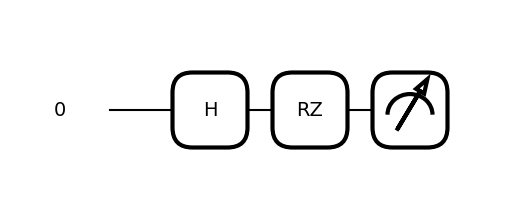

In [31]:
dev = qml.device("default.qubit", wires=1)

def evolve_plus_state(B, time):
    e = 1.6e-19
    m_e = 9.1e-31
    alpha = B*e/(2*m_e)
    qml.Hadamard(0)
    qml.RZ(-2*alpha*time, wires=0)
    
@qml.qnode(dev)
def mag_z_plus_X(B, time):
    evolve_plus_state(B, time)
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev)
def mag_z_plus_Y(B, time):
    evolve_plus_state(B, time)
    return qml.expval(qml.PauliY(0))

qml.draw_mpl(mag_z_plus_X)(0.1, 0.6)


### Linear combination of unitaries.

In [32]:
aux = 0
main = 1
n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

def add_two_unitaries(U, V):
    qml.Hadamard(wires=aux)
    qml.ControlledQubitUnitary(U, control_wires=[0], wires=1, control_values=[0])
    qml.ControlledQubitUnitary(V, control_wires=[0], wires=1, control_values=[1])
    qml.Hadamard(wires=aux)

@qml.qnode(dev)
def X_plus_Z():
    add_two_unitaries(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix())
    return qml.state()

print("The amplitudes on the main register are proportional to", X_plus_Z()[:2], ".")


The amplitudes on the main register are proportional to [0.5+0.j 0.5+0.j] .


### First order implementation 

In [33]:
def V(t):
    return np.array(
        [
            [np.sqrt(t) / np.sqrt(t + 1), -1 / np.sqrt(t + 1)],
            [1 / np.sqrt(t + 1), np.sqrt(t) / np.sqrt(t + 1)],
        ]
    )

def exp_U_first(U, t):
    qml.QubitUnitary(V(t), wires=0)
    qml.ControlledQubitUnitary(U, control_wires=0, wires=1, control_values="0")
    qml.QubitUnitary(np.transpose(V(t)), wires=0)


### Implement unitary for the following. 

$ H \otimes X + H \otimes Z $
$ = (X + Z) \otimes X + (X + Z) \otimes Z = X \otimes X + Z \otimes Z + X \otimes Z + Z \otimes X $

The amplitudes on the main register are proportional to [ 0.25+0.j -0.25+0.j  0.25+0.j -0.25+0.j] .


/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(
/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


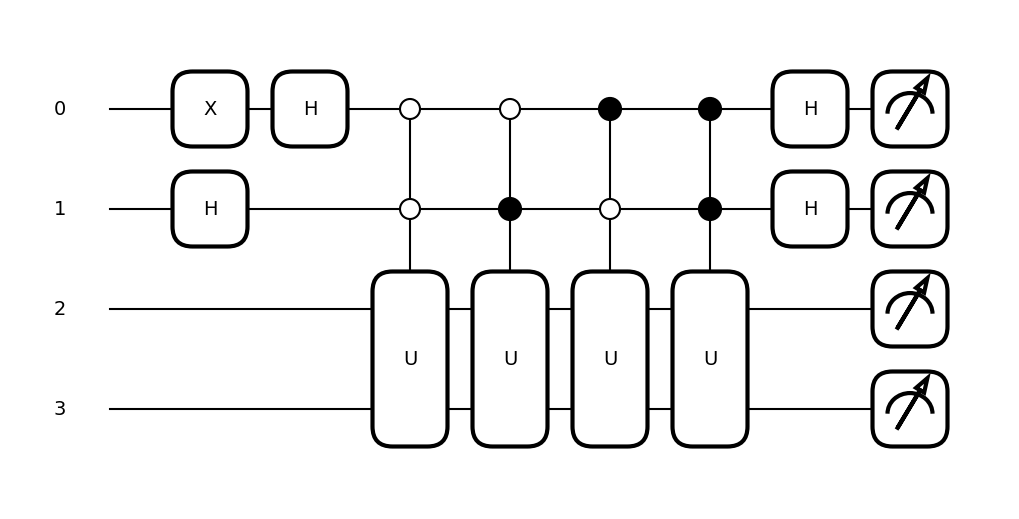

In [34]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def SELECT_uniform(U_list):
    for index in range(2**k_bits):
        ctrl_str =  np.binary_repr(index, k_bits) # Create binary representation
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, wires=main, control_values=ctrl_str)

@qml.qnode(dev)
def XH_plus_HZ():
    """Apply XH + HZ to |01> and return the state."""
    
    U_list = [
        np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
    ]
    
    qml.PauliX(0)
    
    for i in aux:
        qml.Hadamard(i)
    
    SELECT_uniform(U_list[::-1])
    
    for i in aux:
        qml.Hadamard(i)    
    
    return qml.state()

qml.draw_mpl(XH_plus_HZ)()

print("The amplitudes on the main register are proportional to", XH_plus_HZ()[:4], ".")


### Second order implemenation of exponentiation,

[0.2  0.32 0.4  0.08]


/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


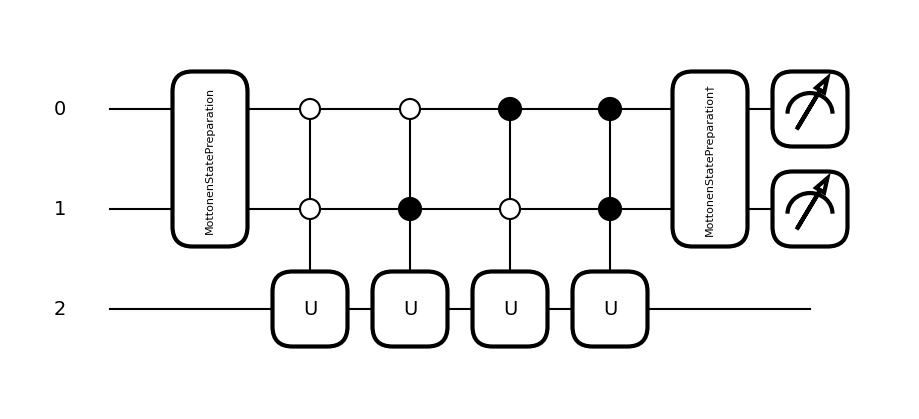

In [35]:
k_bits = 2
n_bits = 1
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def prepare(coeffs):
    coeffs_norm = coeffs / np.linalg.norm(coeffs)    
    qml.MottonenStatePreparation(coeffs_norm, wires=[0,1])

def select(unitaries):
    for i in range(len(unitaries)):
        ctrl_str =  np.binary_repr(i, 2)
        qml.ControlledQubitUnitary(unitaries[i], control_wires=aux, wires=main, control_values=ctrl_str)

def v0(t):
    denomin = 1/ np.sqrt(1+t+(t**2/2))
    v00 = 1/denomin
    v01 = np.sqrt(t)/denomin
    v02 = (t/np.sqrt(2))/denomin
    v03 = 0
    return [v00, v01, v02, v03]/np.linalg.norm([v00, v01, v02, v03])

@qml.qnode(dev)
def exp_U_second(unitaries, t):
    coeffs = v0(t)
    prepare(coeffs)
    select(unitaries)
    qml.adjoint(qml.MottonenStatePreparation(coeffs, wires=[0,1]))
    return qml.probs(wires=[0,1])

unitary = -1j * qml.PauliZ.compute_matrix()

qml.draw_mpl(exp_U_second)([np.eye(2), unitary, unitary**2, unitary**3], 1)

print (qml.QNode(exp_U_second, dev)([np.eye(2), unitary, unitary**2, unitary**3], 1))



### First order and second order taylor series unitaries

In [48]:
aux = [0, 1]
main = [2]
all_bits = aux + main

U = qml.PauliX.compute_matrix()*(1.j)
unitaries = [np.eye(2), U, U @ U, np.eye(2)] # U0, U1, U2, U3

dev1 = qml.device("default.qubit", wires=[0,1])
dev2 = qml.device("default.qubit", wires=all_bits)

# H.6.3
@qml.qnode(dev1)
def first_approx(t):
    exp_U_first(U, t)
    return qml.probs(wires=[0])

# H.6.4
@qml.qnode(dev2)
def second_approx(t):
    exp_U_second(unitaries, t)
    return qml.probs(wires=[0,1])

# Exact Hamiltonian evolution
@qml.qnode(dev2)
def exact(t):
    qml.RX(-2*(t), wires=main)
    return qml.probs(wires=[0,1])

print ("first order = ", qml.QNode(first_approx, dev1)(0.9))
print ("second order = ", qml.QNode(second_approx, dev2)(0.9))
print ("Exact order = ", qml.QNode(exact, dev2)(0.9))


first order =  [0.50138504 0.49861496]
second order =  [1. 0. 0. 0.]
Exact order =  [1. 0. 0. 0.]


Apply linear transformation to the state $ H \otimes (X+Z/2) = (X + Z) \otimes (X + Z/2) = X \otimes X + 1/2 (X \otimes Z) + 1/2 (X \otimes Z) + (Z \otimes X)$

The amplitudes on the main register are proportional to [0.33626291 0.10010848 0.10010848 0.14106318] .


/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:253: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


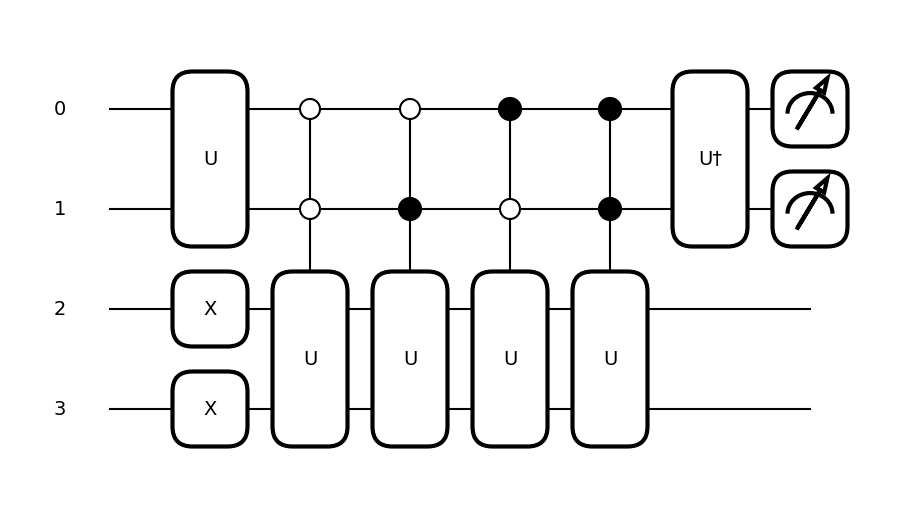

In [79]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def householder(state):
    o = 2 * np.outer(state, state)
    return np.eye(o.shape[0]) - o

def PREPARE(alpha_list):
    zero_vec = np.array([1] + [0]*(2**k_bits - 1))
    alpha_list = alpha_list/np.linalg.norm(alpha_list)
    return householder(zero_vec - alpha_list)

U_list = [np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix())]
alpha_list = [1, 0.5, 0.5, 1]

def SELECT(U_list):
    for index in range(2**k_bits):
        ctrl_str = np.binary_repr(index, k_bits) # Create binary representation
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, 
                                   wires=main, control_values=ctrl_str)

def LCU(alpha_list, U_list):    
    qml.QubitUnitary(PREPARE(alpha_list), wires=aux, id="alpha")
    SELECT(U_list)
    qml.adjoint(qml.QubitUnitary(PREPARE(alpha_list), wires=aux))

@qml.qnode(dev)
def my_circuit():
    qml.PauliX(wires=2)
    qml.PauliX(wires=3)
    LCU(alpha_list, U_list)
    return qml.probs([0,1])

qml.draw_mpl(my_circuit)()

print("The amplitudes on the main register are proportional to", my_circuit()[:4], ".")


### Produce bell state with linear hamilton combinations

In [104]:
@qml.qnode(dev)
def quantum_memory(beta_list):
    U_list = [
        np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
        ]
    
    beta_j = [i*i for i in beta_list]
    
    LCU(beta_j, U_list)
    
    return qml.state()

beta_list = [1, 0, 0, 1]
normalized_coefficients = [quantum_memory(beta_list)[i].item() for i in range(0, 20, 5)]
print("The amplitudes on the main register are proportional to", normalized_coefficients, ".")


The amplitudes on the main register are proportional to [(0.17157287525380993+0j), 0j, 0j, (0.3431457505076198+0j)] .
